# 2 Layer Neural Network

## Imports

In [1]:
import os
import pandas as pd

## Import data and create .csv

In [2]:
# Directory to MRI Images
base_dir = '/Users/venkatasaikrishna.gudladona/src/machinelearning/229FinalProject/AugmentedAlzheimerDataset'
classes = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

if not os.path.exists('dataset.csv'):
    data = []

    for label, class_name in enumerate(classes):
        class_dir = os.path.join(base_dir, class_name)
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            data.append([image_path, label])

    df = pd.DataFrame(data, columns=['path', 'label'])
    df.to_csv('dataset.csv', index=False)

## Data Loading and Pre-Processing

In [3]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.dataframe = pd.read_csv(csv_file)
        self.dataframe = self.dataframe.sample(frac=1).reset_index(drop=True)  # Shuffle the dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]
        image = Image.open(img_name)
        label = int(self.dataframe.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image to 224 X 224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    #transforms.Lambda(lambda x: x.view(-1))  # Flatten the image
])

# Load the entire dataset
dataset = CustomDataset(csv_file='dataset.csv', transform=transform)

# Split the dataset into train, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [4]:
print(f'Training Samples: {len(train_dataset)}')
print(f'Validation Samples: {len(val_dataset)}')
print(f'Test Samples: {len(test_dataset)}')

Training Samples: 23788
Validation Samples: 5097
Test Samples: 5099


In [5]:
print(train_dataset)

In [6]:
import matplotlib.pyplot as plt
#plt.plot(train_dataset[0][0])
#plt.show()

## Pytorch Logistic Regression Model

In [7]:
class FiveLayerNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, output_dim):
        super(FiveLayerNN, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim1)
        self.fc2 = torch.nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = torch.nn.Linear(hidden_dim2, hidden_dim3)
        self.fc4 = torch.nn.Linear(hidden_dim3, hidden_dim4)
        self.fc5 = torch.nn.Linear(hidden_dim4, output_dim)

    def forward(self, x):
        #x = x.view(-1, 224 * 224 * 3)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x

input_dim = 224 * 224 * 3  # Assuming the images are RGB
hidden_dim1 = 512
hidden_dim2 = 256
hidden_dim3 = 128
hidden_dim4 = 64
output_dim = 4  # Four classes

#model = FiveLayerNN(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, output_dim)
import torchvision
from torchvision.models import resnet18, ResNet18_Weights
model = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

model.fc = torch.nn.Linear(model.fc.in_features, output_dim)


## Training Loop

In [8]:
learning_rate = 0.01
num_epochs = 20
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.RMSProp(model.parameters(), lr=learning_rate)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
print('current lr=', optimizer.param_groups[0]['lr'])

# Initialize lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0

    i = 0
    for inputs, labels in train_loader:
        i = i + 1
        print("Training continues..", total_train_loss, "current i = ", i)    
        optimizer.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)        
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        
        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    total_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        print("Computing validation accuaracy")
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    #lr decay
    lr_scheduler.step()

    print(f"Epoch {epoch}: Train Loss: {avg_train_loss}, Train Accuracy: {train_accuracy}%, Val Loss: {avg_val_loss}, Val Accuracy: {val_accuracy}%")
    print(f"Iteration {epoch} lr = {optimizer.param_groups[0]['lr']} - Loss = {total_train_loss / len(train_loader)}")

current lr= 0.01
Training continues.. 0.0 current i =  1
Training continues.. 1.690069556236267 current i =  2
Training continues.. 3.1617735624313354 current i =  3
Training continues.. 4.6618332862854 current i =  4
Training continues.. 6.296191930770874 current i =  5
Training continues.. 7.582834959030151 current i =  6
Training continues.. 9.202536225318909 current i =  7
Training continues.. 10.513333201408386 current i =  8
Training continues.. 12.115370988845825 current i =  9
Training continues.. 13.39919114112854 current i =  10
Training continues.. 14.693840503692627 current i =  11
Training continues.. 15.934899091720581 current i =  12
Training continues.. 17.18445348739624 current i =  13
Training continues.. 18.495681166648865 current i =  14
Training continues.. 19.491154372692108 current i =  15
Training continues.. 20.642676055431366 current i =  16
Training continues.. 21.623469829559326 current i =  17
Training continues.. 22.9077650308609 current i =  18
Training c

Training continues.. 102.75261799991131 current i =  149
Training continues.. 103.12509645521641 current i =  150
Training continues.. 103.67885948717594 current i =  151
Training continues.. 104.15012745559216 current i =  152
Training continues.. 104.57758609950542 current i =  153
Training continues.. 104.87143029272556 current i =  154
Training continues.. 105.1205657273531 current i =  155
Training continues.. 105.57896174490452 current i =  156
Training continues.. 106.04982624948025 current i =  157
Training continues.. 106.40869216620922 current i =  158
Training continues.. 106.73470668494701 current i =  159
Training continues.. 107.0447930842638 current i =  160
Training continues.. 107.53316824138165 current i =  161
Training continues.. 107.75806319713593 current i =  162
Training continues.. 108.09337323904037 current i =  163
Training continues.. 108.4055403470993 current i =  164
Training continues.. 109.08729100227356 current i =  165
Training continues.. 109.348272830

Training continues.. 148.4460735246539 current i =  294
Training continues.. 148.72824879735708 current i =  295
Training continues.. 148.90832621604204 current i =  296
Training continues.. 149.03743491321802 current i =  297
Training continues.. 149.21240652352571 current i =  298
Training continues.. 149.43862564116716 current i =  299
Training continues.. 149.73224023729563 current i =  300
Training continues.. 150.02826026827097 current i =  301
Training continues.. 150.22576501220465 current i =  302
Training continues.. 150.60852836817503 current i =  303
Training continues.. 150.730479426682 current i =  304
Training continues.. 150.92760983854532 current i =  305
Training continues.. 151.2923827841878 current i =  306
Training continues.. 151.47326173633337 current i =  307
Training continues.. 151.6112705245614 current i =  308
Training continues.. 151.8746241107583 current i =  309
Training continues.. 152.3037925735116 current i =  310
Training continues.. 152.4869978055358

Training continues.. 6.903756436891854 current i =  65
Training continues.. 7.110372704453766 current i =  66
Training continues.. 7.215843831188977 current i =  67
Training continues.. 7.295728807337582 current i =  68
Training continues.. 7.309067955240607 current i =  69
Training continues.. 7.44997944496572 current i =  70
Training continues.. 7.543912878260016 current i =  71
Training continues.. 7.697049727663398 current i =  72
Training continues.. 7.789512349292636 current i =  73
Training continues.. 7.799328398890793 current i =  74
Training continues.. 7.88193588424474 current i =  75
Training continues.. 7.973011498339474 current i =  76
Training continues.. 8.021517810411751 current i =  77
Training continues.. 8.173261207528412 current i =  78
Training continues.. 8.243440170772374 current i =  79
Training continues.. 8.393206332810223 current i =  80
Training continues.. 8.620044355280697 current i =  81
Training continues.. 8.659758587367833 current i =  82
Training con

Training continues.. 21.056647960096598 current i =  211
Training continues.. 21.252602506428957 current i =  212
Training continues.. 21.454803753644228 current i =  213
Training continues.. 21.61539303138852 current i =  214
Training continues.. 21.7391965277493 current i =  215
Training continues.. 22.001858491450548 current i =  216
Training continues.. 22.159858513623476 current i =  217
Training continues.. 22.237950447946787 current i =  218
Training continues.. 22.490264181047678 current i =  219
Training continues.. 22.591216180473566 current i =  220
Training continues.. 22.77677259221673 current i =  221
Training continues.. 22.97115357592702 current i =  222
Training continues.. 23.04310730472207 current i =  223
Training continues.. 23.12482774630189 current i =  224
Training continues.. 23.489713344722986 current i =  225
Training continues.. 23.610098529607058 current i =  226
Training continues.. 23.77075669541955 current i =  227
Training continues.. 23.88375648483634 

Training continues.. 34.727255620993674 current i =  357
Training continues.. 34.79447072092444 current i =  358
Training continues.. 34.828171347267926 current i =  359
Training continues.. 34.99075583089143 current i =  360
Training continues.. 35.07606915105134 current i =  361
Training continues.. 35.11527978722006 current i =  362
Training continues.. 35.14483237545937 current i =  363
Training continues.. 35.18128954898566 current i =  364
Training continues.. 35.210671191103756 current i =  365
Training continues.. 35.24202217254788 current i =  366
Training continues.. 35.265647171996534 current i =  367
Training continues.. 35.28566200006753 current i =  368
Training continues.. 35.42944005597383 current i =  369
Training continues.. 35.47166683617979 current i =  370
Training continues.. 35.533553128130734 current i =  371
Training continues.. 35.630910341627896 current i =  372
Computing validation accuaracy
Epoch 1: Train Loss: 0.09582983459826679, Train Accuracy: 96.401546

Training continues.. 6.358036030782387 current i =  129
Training continues.. 6.380178176565096 current i =  130
Training continues.. 6.387935212580487 current i =  131
Training continues.. 6.444962254492566 current i =  132
Training continues.. 6.467151072574779 current i =  133
Training continues.. 6.492245451314375 current i =  134
Training continues.. 6.522669919533655 current i =  135
Training continues.. 6.545632728142664 current i =  136
Training continues.. 6.5724523949902505 current i =  137
Training continues.. 6.673024995950982 current i =  138
Training continues.. 6.690226710168645 current i =  139
Training continues.. 6.7719704795163125 current i =  140
Training continues.. 6.816019817022607 current i =  141
Training continues.. 6.904082312015817 current i =  142
Training continues.. 6.909759996226057 current i =  143
Training continues.. 7.0251258292701095 current i =  144
Training continues.. 7.040541092632338 current i =  145
Training continues.. 7.1345533828716725 curre

Training continues.. 11.66941085853614 current i =  275
Training continues.. 11.679767223307863 current i =  276
Training continues.. 11.681407670374028 current i =  277
Training continues.. 11.712328093941323 current i =  278
Training continues.. 11.739767013932578 current i =  279
Training continues.. 11.77074181928765 current i =  280
Training continues.. 11.853888957644813 current i =  281
Training continues.. 11.861765484209172 current i =  282
Training continues.. 11.865727612166665 current i =  283
Training continues.. 11.89111767464783 current i =  284
Training continues.. 11.89398022450041 current i =  285
Training continues.. 11.911567927221768 current i =  286
Training continues.. 11.923855508561246 current i =  287
Training continues.. 11.956451891805045 current i =  288
Training continues.. 11.962922647944652 current i =  289
Training continues.. 11.9638629531255 current i =  290
Training continues.. 11.979424575692974 current i =  291
Training continues.. 12.0111282378202

Training continues.. 1.282736824679887 current i =  45
Training continues.. 1.310808455426013 current i =  46
Training continues.. 1.3199873825942632 current i =  47
Training continues.. 1.3301101623510476 current i =  48
Training continues.. 1.338817836571252 current i =  49
Training continues.. 1.3582862725888845 current i =  50
Training continues.. 1.376471847150242 current i =  51
Training continues.. 1.3806127946299966 current i =  52
Training continues.. 1.388270989380544 current i =  53
Training continues.. 1.407519230939215 current i =  54
Training continues.. 1.423034565843409 current i =  55
Training continues.. 1.4264091584773269 current i =  56
Training continues.. 1.4527204852493014 current i =  57
Training continues.. 1.5026066634745803 current i =  58
Training continues.. 1.5635600421519484 current i =  59
Training continues.. 1.6208936717303004 current i =  60
Training continues.. 1.6786937262804713 current i =  61
Training continues.. 1.6896139332966413 current i =  62

Training continues.. 4.677017933194293 current i =  192
Training continues.. 4.700818697427167 current i =  193
Training continues.. 4.702544800325995 current i =  194
Training continues.. 4.702955621061847 current i =  195
Training continues.. 4.705881408881396 current i =  196
Training continues.. 4.710202965885401 current i =  197
Training continues.. 4.741665035486221 current i =  198
Training continues.. 4.74406895483844 current i =  199
Training continues.. 4.7601734574418515 current i =  200
Training continues.. 4.763773717917502 current i =  201
Training continues.. 4.764826243626885 current i =  202
Training continues.. 4.8231972138164565 current i =  203
Training continues.. 4.8273045922396705 current i =  204
Training continues.. 4.843021849053912 current i =  205
Training continues.. 4.852137802052312 current i =  206
Training continues.. 4.874290585401468 current i =  207
Training continues.. 4.91810898098629 current i =  208
Training continues.. 4.919461045064963 current 

Training continues.. 8.244564830383752 current i =  339
Training continues.. 8.255589392094407 current i =  340
Training continues.. 8.256871513614897 current i =  341
Training continues.. 8.265823449532036 current i =  342
Training continues.. 8.268610717554111 current i =  343
Training continues.. 8.277647971000988 current i =  344
Training continues.. 8.331546111789066 current i =  345
Training continues.. 8.334445536194835 current i =  346
Training continues.. 8.350301418511663 current i =  347
Training continues.. 8.361529092362616 current i =  348
Training continues.. 8.38886415498564 current i =  349
Training continues.. 8.389445055567194 current i =  350
Training continues.. 8.417220320843626 current i =  351
Training continues.. 8.428559957363177 current i =  352
Training continues.. 8.436705966771115 current i =  353
Training continues.. 8.442069607612211 current i =  354
Training continues.. 8.443168477795552 current i =  355
Training continues.. 8.443645221123006 current i 

Training continues.. 1.1507233722368255 current i =  110
Training continues.. 1.1946091098943725 current i =  111
Training continues.. 1.2017530259909108 current i =  112
Training continues.. 1.2021905634901486 current i =  113
Training continues.. 1.206608481646981 current i =  114
Training continues.. 1.2070236316649243 current i =  115
Training continues.. 1.2163028082577512 current i =  116
Training continues.. 1.2175119266612455 current i =  117
Training continues.. 1.2212664702674374 current i =  118
Training continues.. 1.2217511476483196 current i =  119
Training continues.. 1.2361193501856178 current i =  120
Training continues.. 1.2418086912948638 current i =  121
Training continues.. 1.2637348093558103 current i =  122
Training continues.. 1.273388534085825 current i =  123
Training continues.. 1.2827627419028431 current i =  124
Training continues.. 1.3110524250660092 current i =  125
Training continues.. 1.3210314598400146 current i =  126
Training continues.. 1.3281560458

Training continues.. 2.2118433591385838 current i =  255
Training continues.. 2.2123764778662007 current i =  256
Training continues.. 2.212944938772125 current i =  257
Training continues.. 2.2138158618763555 current i =  258
Training continues.. 2.2145422437170055 current i =  259
Training continues.. 2.214655272597156 current i =  260
Training continues.. 2.2195705496051232 current i =  261
Training continues.. 2.220057277554588 current i =  262
Training continues.. 2.2215952738988562 current i =  263
Training continues.. 2.221875309063762 current i =  264
Training continues.. 2.240150135992735 current i =  265
Training continues.. 2.249070677025884 current i =  266
Training continues.. 2.2500552202618564 current i =  267
Training continues.. 2.2517973302674363 current i =  268
Training continues.. 2.253781452709518 current i =  269
Training continues.. 2.254907393064059 current i =  270
Training continues.. 2.259897979143716 current i =  271
Training continues.. 2.2603160575890797 

Training continues.. 0.048736627995822346 current i =  25
Training continues.. 0.04894553946724045 current i =  26
Training continues.. 0.049037462118576514 current i =  27
Training continues.. 0.04989825918528368 current i =  28
Training continues.. 0.052394953399925726 current i =  29
Training continues.. 0.05258321825021994 current i =  30
Training continues.. 0.05318693181106937 current i =  31
Training continues.. 0.053372553335066186 current i =  32
Training continues.. 0.05364339407606167 current i =  33
Training continues.. 0.053773400071804645 current i =  34
Training continues.. 0.07265920068675769 current i =  35
Training continues.. 0.07328447948748362 current i =  36
Training continues.. 0.0735407204956573 current i =  37
Training continues.. 0.07407485605290276 current i =  38
Training continues.. 0.11144567192604882 current i =  39
Training continues.. 0.11250974405629677 current i =  40
Training continues.. 0.11380629758423311 current i =  41
Training continues.. 0.1185

Training continues.. 0.32872929751283664 current i =  169
Training continues.. 0.32933613379827875 current i =  170
Training continues.. 0.32938451545305725 current i =  171
Training continues.. 0.32966936366392474 current i =  172
Training continues.. 0.33067775632480334 current i =  173
Training continues.. 0.33393711082862865 current i =  174
Training continues.. 0.3353615819778497 current i =  175
Training continues.. 0.33557397352524276 current i =  176
Training continues.. 0.33572972906222276 current i =  177
Training continues.. 0.33751386476615153 current i =  178
Training continues.. 0.3381223825545021 current i =  179
Training continues.. 0.33820626526539854 current i =  180
Training continues.. 0.3384219963754731 current i =  181
Training continues.. 0.3391171707025933 current i =  182
Training continues.. 0.33927005402620125 current i =  183
Training continues.. 0.34009675950619567 current i =  184
Training continues.. 0.3401328129457397 current i =  185
Training continues.

Training continues.. 0.5934944556238406 current i =  313
Training continues.. 0.5936409538871885 current i =  314
Training continues.. 0.5936617653815119 current i =  315
Training continues.. 0.5937421028093013 current i =  316
Training continues.. 0.593861698182991 current i =  317
Training continues.. 0.5941184423090817 current i =  318
Training continues.. 0.5950382106630059 current i =  319
Training continues.. 0.5953225547373222 current i =  320
Training continues.. 0.5954726319278052 current i =  321
Training continues.. 0.5963565998345075 current i =  322
Training continues.. 0.5964193719073592 current i =  323
Training continues.. 0.5965356423212143 current i =  324
Training continues.. 0.5966937318398777 current i =  325
Training continues.. 0.5970667598840009 current i =  326
Training continues.. 0.5996676409222346 current i =  327
Training continues.. 0.5996895278976808 current i =  328
Training continues.. 0.5998535314311084 current i =  329
Training continues.. 0.601091404

Training continues.. 0.04112538341541949 current i =  81
Training continues.. 0.04191700056071568 current i =  82
Training continues.. 0.041981678927186294 current i =  83
Training continues.. 0.04321890685787366 current i =  84
Training continues.. 0.05217810615977214 current i =  85
Training continues.. 0.052500845084068715 current i =  86
Training continues.. 0.05263202966852987 current i =  87
Training continues.. 0.05396358171674365 current i =  88
Training continues.. 0.05408740777602361 current i =  89
Training continues.. 0.06284965656777786 current i =  90
Training continues.. 0.0653663185712503 current i =  91
Training continues.. 0.06556613316024595 current i =  92
Training continues.. 0.06593471527412476 current i =  93
Training continues.. 0.06600788375180855 current i =  94
Training continues.. 0.06610001614717476 current i =  95
Training continues.. 0.06676874015647627 current i =  96
Training continues.. 0.0668281510425004 current i =  97
Training continues.. 0.06704502

Training continues.. 0.1488417158525408 current i =  223
Training continues.. 0.14887114958946768 current i =  224
Training continues.. 0.1489613159046712 current i =  225
Training continues.. 0.14913301601882267 current i =  226
Training continues.. 0.15571575485046196 current i =  227
Training continues.. 0.1557754982914048 current i =  228
Training continues.. 0.1558593993086106 current i =  229
Training continues.. 0.15598943921031605 current i =  230
Training continues.. 0.15619525385955058 current i =  231
Training continues.. 0.15623799285276618 current i =  232
Training continues.. 0.15639151628602121 current i =  233
Training continues.. 0.15650618671679695 current i =  234
Training continues.. 0.15675721039769996 current i =  235
Training continues.. 0.15681444369874953 current i =  236
Training continues.. 0.15690820260533656 current i =  237
Training continues.. 0.15712325660024362 current i =  238
Training continues.. 0.15719749574964226 current i =  239
Training continues

Training continues.. 0.21957638108233368 current i =  365
Training continues.. 0.22013945894377684 current i =  366
Training continues.. 0.22020016328042402 current i =  367
Training continues.. 0.22037308184098947 current i =  368
Training continues.. 0.22082070844498958 current i =  369
Training continues.. 0.2210452756817176 current i =  370
Training continues.. 0.22114228535519942 current i =  371
Training continues.. 0.22291143316851958 current i =  372
Computing validation accuaracy
Epoch 6: Train Loss: 0.0005994111446564417, Train Accuracy: 100.0%, Val Loss: 0.013562737313441176, Val Accuracy: 99.43103786541103%
Iteration 6 lr = 0.001 - Loss = 0.0005994111446564417
Training continues.. 0.0 current i =  1
Training continues.. 0.011199552565813065 current i =  2
Training continues.. 0.011452474805992097 current i =  3
Training continues.. 0.011595362215302885 current i =  4
Training continues.. 0.012707989546470344 current i =  5
Training continues.. 0.012739551799313631 current i

Training continues.. 0.10247279882423754 current i =  133
Training continues.. 0.10263949267209682 current i =  134
Training continues.. 0.10270985967326851 current i =  135
Training continues.. 0.10288450464395282 current i =  136
Training continues.. 0.10290033842284174 current i =  137
Training continues.. 0.10316442716248275 current i =  138
Training continues.. 0.10340086307223828 current i =  139
Training continues.. 0.1035673386995768 current i =  140
Training continues.. 0.10387675112542638 current i =  141
Training continues.. 0.10396333917560696 current i =  142
Training continues.. 0.10409202836854092 current i =  143
Training continues.. 0.10415876732986362 current i =  144
Training continues.. 0.11253883579593094 current i =  145
Training continues.. 0.11263541168409574 current i =  146
Training continues.. 0.11265171205195657 current i =  147
Training continues.. 0.11278466984549596 current i =  148
Training continues.. 0.11282517029940209 current i =  149
Training contin

Training continues.. 0.16373366462539707 current i =  275
Training continues.. 0.16382610114123963 current i =  276
Training continues.. 0.164054775976183 current i =  277
Training continues.. 0.16418039323070843 current i =  278
Training continues.. 0.164207603678733 current i =  279
Training continues.. 0.1644809226399957 current i =  280
Training continues.. 0.1653061953966244 current i =  281
Training continues.. 0.16532371264111134 current i =  282
Training continues.. 0.16549742007555324 current i =  283
Training continues.. 0.1655753937047848 current i =  284
Training continues.. 0.16568478398767184 current i =  285
Training continues.. 0.1658267017592152 current i =  286
Training continues.. 0.16589509330151486 current i =  287
Training continues.. 0.17231843394620228 current i =  288
Training continues.. 0.17240488235620433 current i =  289
Training continues.. 0.17260270814949763 current i =  290
Training continues.. 0.17262478533302783 current i =  291
Training continues.. 0

Training continues.. 0.010197795321801095 current i =  42
Training continues.. 0.010372437163823633 current i =  43
Training continues.. 0.010418644209494232 current i =  44
Training continues.. 0.010545413073486998 current i =  45
Training continues.. 0.010674545896108611 current i =  46
Training continues.. 0.011186181805896922 current i =  47
Training continues.. 0.012043888162224903 current i =  48
Training continues.. 0.013491239229551866 current i =  49
Training continues.. 0.013933227170127793 current i =  50
Training continues.. 0.014100284262895002 current i =  51
Training continues.. 0.014136087613223935 current i =  52
Training continues.. 0.014755070382307167 current i =  53
Training continues.. 0.014880042273944127 current i =  54
Training continues.. 0.015149749624470132 current i =  55
Training continues.. 0.015190447707936983 current i =  56
Training continues.. 0.017899025491715292 current i =  57
Training continues.. 0.018072841890898417 current i =  58
Training conti

Training continues.. 0.0675409198502166 current i =  184
Training continues.. 0.06760465392835613 current i =  185
Training continues.. 0.06778305399166129 current i =  186
Training continues.. 0.06791546566637408 current i =  187
Training continues.. 0.06796331379337062 current i =  188
Training continues.. 0.0681645754539204 current i =  189
Training continues.. 0.0682751349031605 current i =  190
Training continues.. 0.06830654602345021 current i =  191
Training continues.. 0.06834680034990015 current i =  192
Training continues.. 0.06848309894303384 current i =  193
Training continues.. 0.06952995417850616 current i =  194
Training continues.. 0.06970326188638865 current i =  195
Training continues.. 0.06974850901860918 current i =  196
Training continues.. 0.06978273131062451 current i =  197
Training continues.. 0.0698359696634725 current i =  198
Training continues.. 0.0698579093132139 current i =  199
Training continues.. 0.06996310115027882 current i =  200
Training continues.

Training continues.. 0.10769621055987955 current i =  326
Training continues.. 0.10783193956194737 current i =  327
Training continues.. 0.1078745393515419 current i =  328
Training continues.. 0.1083554392298538 current i =  329
Training continues.. 0.10856156368936354 current i =  330
Training continues.. 0.10859800840080425 current i =  331
Training continues.. 0.10888512490600988 current i =  332
Training continues.. 0.10938053158861294 current i =  333
Training continues.. 0.10950942255840346 current i =  334
Training continues.. 0.1096248474332242 current i =  335
Training continues.. 0.10982687027535576 current i =  336
Training continues.. 0.11017507624455902 current i =  337
Training continues.. 0.11041634488901764 current i =  338
Training continues.. 0.11052266770821007 current i =  339
Training continues.. 0.11116065038913803 current i =  340
Training continues.. 0.11162786244494782 current i =  341
Training continues.. 0.1118038256008731 current i =  342
Training continues

Training continues.. 0.025620661335779005 current i =  93
Training continues.. 0.02600243979577499 current i =  94
Training continues.. 0.026555378639386618 current i =  95
Training continues.. 0.02662379103458079 current i =  96
Training continues.. 0.02671324172297318 current i =  97
Training continues.. 0.026754346397865447 current i =  98
Training continues.. 0.026967171970682102 current i =  99
Training continues.. 0.028878851137051242 current i =  100
Training continues.. 0.028991887438678532 current i =  101
Training continues.. 0.02901857368487981 current i =  102
Training continues.. 0.029118275411747163 current i =  103
Training continues.. 0.02921260442599305 current i =  104
Training continues.. 0.03246604153900989 current i =  105
Training continues.. 0.03258054840625846 current i =  106
Training continues.. 0.032854804336238885 current i =  107
Training continues.. 0.033297805584879825 current i =  108
Training continues.. 0.03332425518965465 current i =  109
Training con

Training continues.. 0.07503412311416469 current i =  235
Training continues.. 0.07504245622658345 current i =  236
Training continues.. 0.07520645382282964 current i =  237
Training continues.. 0.07553273657504178 current i =  238
Training continues.. 0.07595422447593592 current i =  239
Training continues.. 0.07600616621675726 current i =  240
Training continues.. 0.07602974896508385 current i =  241
Training continues.. 0.0767245486676984 current i =  242
Training continues.. 0.07698421371242148 current i =  243
Training continues.. 0.07713566463280586 current i =  244
Training continues.. 0.07716547138079477 current i =  245
Training continues.. 0.07743818588460272 current i =  246
Training continues.. 0.07752607689144497 current i =  247
Training continues.. 0.07761255272453127 current i =  248
Training continues.. 0.07764655933169706 current i =  249
Training continues.. 0.07779150784517697 current i =  250
Training continues.. 0.07795695904678723 current i =  251
Training contin

Training continues.. 0.0 current i =  1
Training continues.. 6.256256892811507e-05 current i =  2
Training continues.. 0.00015621547208866104 current i =  3
Training continues.. 0.000266285082034301 current i =  4
Training continues.. 0.0003209576098015532 current i =  5
Training continues.. 0.00042874491191469133 current i =  6
Training continues.. 0.004222071351250634 current i =  7
Training continues.. 0.004741551732877269 current i =  8
Training continues.. 0.004756763362820493 current i =  9
Training continues.. 0.004797628789674491 current i =  10
Training continues.. 0.005020814336603507 current i =  11
Training continues.. 0.005270049354294315 current i =  12
Training continues.. 0.0054488049645442516 current i =  13
Training continues.. 0.005470787658850895 current i =  14
Training continues.. 0.005666378234309377 current i =  15
Training continues.. 0.006387893623468699 current i =  16
Training continues.. 0.006479706662503304 current i =  17
Training continues.. 0.0065355335

Training continues.. 0.032981939960336604 current i =  143
Training continues.. 0.03300598749319761 current i =  144
Training continues.. 0.03339114060054271 current i =  145
Training continues.. 0.03384240887953638 current i =  146
Training continues.. 0.0340951461066652 current i =  147
Training continues.. 0.034123731965337356 current i =  148
Training continues.. 0.03423756574102299 current i =  149
Training continues.. 0.03666986598454969 current i =  150
Training continues.. 0.0372260880894828 current i =  151
Training continues.. 0.037275285568284744 current i =  152
Training continues.. 0.03744042369999079 current i =  153
Training continues.. 0.03746351440622675 current i =  154
Training continues.. 0.03873180252685415 current i =  155
Training continues.. 0.038804668186458 current i =  156
Training continues.. 0.03912983955069649 current i =  157
Training continues.. 0.03919870861409436 current i =  158
Training continues.. 0.03930665381903964 current i =  159
Training contin

Training continues.. 0.082027463347913 current i =  285
Training continues.. 0.08240769968324457 current i =  286
Training continues.. 0.08247082127127214 current i =  287
Training continues.. 0.08266873740285519 current i =  288
Training continues.. 0.08274730977063882 current i =  289
Training continues.. 0.08341990918779629 current i =  290
Training continues.. 0.08359352407205733 current i =  291
Training continues.. 0.08363810052469489 current i =  292
Training continues.. 0.08413506175929797 current i =  293
Training continues.. 0.08451253014573012 current i =  294
Training continues.. 0.08458895081639639 current i =  295
Training continues.. 0.08478905868469155 current i =  296
Training continues.. 0.08490261740007554 current i =  297
Training continues.. 0.08504655673823436 current i =  298
Training continues.. 0.08558090044607525 current i =  299
Training continues.. 0.08561663074578973 current i =  300
Training continues.. 0.08571238204967813 current i =  301
Training continu

Training continues.. 0.010727670993219363 current i =  51
Training continues.. 0.011270779785263585 current i =  52
Training continues.. 0.011663550034427317 current i =  53
Training continues.. 0.011765378647396574 current i =  54
Training continues.. 0.01197340217549936 current i =  55
Training continues.. 0.012023763942124788 current i =  56
Training continues.. 0.012083097928552888 current i =  57
Training continues.. 0.012159854493802413 current i =  58
Training continues.. 0.012472527945647016 current i =  59
Training continues.. 0.012761515768943354 current i =  60
Training continues.. 0.013200465153204277 current i =  61
Training continues.. 0.013215586949627323 current i =  62
Training continues.. 0.013276895623675955 current i =  63
Training continues.. 0.013326348986993253 current i =  64
Training continues.. 0.013498130620973825 current i =  65
Training continues.. 0.013847528974110901 current i =  66
Training continues.. 0.013965052424282476 current i =  67
Training contin

Training continues.. 0.044637499089731136 current i =  192
Training continues.. 0.04465862292636302 current i =  193
Training continues.. 0.046365573409275385 current i =  194
Training continues.. 0.04657916065843892 current i =  195
Training continues.. 0.04686798212424037 current i =  196
Training continues.. 0.047004176671180176 current i =  197
Training continues.. 0.04700783112684803 current i =  198
Training continues.. 0.047057695265266375 current i =  199
Training continues.. 0.04738036172102511 current i =  200
Training continues.. 0.047437279565656354 current i =  201
Training continues.. 0.04754494144481214 current i =  202
Training continues.. 0.047588453166554245 current i =  203
Training continues.. 0.04771011693492255 current i =  204
Training continues.. 0.04777590369167228 current i =  205
Training continues.. 0.047823918634549045 current i =  206
Training continues.. 0.04784257156688909 current i =  207
Training continues.. 0.047878787933314015 current i =  208
Traini

Training continues.. 0.09015531866361925 current i =  334
Training continues.. 0.090234120522382 current i =  335
Training continues.. 0.09034094728167474 current i =  336
Training continues.. 0.09040195677198426 current i =  337
Training continues.. 0.0904384312275397 current i =  338
Training continues.. 0.09080110447803236 current i =  339
Training continues.. 0.09089926152637418 current i =  340
Training continues.. 0.09105349510764427 current i =  341
Training continues.. 0.09113369436499852 current i =  342
Training continues.. 0.09122120202346196 current i =  343
Training continues.. 0.09187628035260786 current i =  344
Training continues.. 0.09200158511930567 current i =  345
Training continues.. 0.09204680790253406 current i =  346
Training continues.. 0.09406820885897105 current i =  347
Training continues.. 0.09428576475011141 current i =  348
Training continues.. 0.09501704552212686 current i =  349
Training continues.. 0.0950640832929821 current i =  350
Training continues

Training continues.. 0.03432757798691455 current i =  101
Training continues.. 0.034356145310084685 current i =  102
Training continues.. 0.03442090617136273 current i =  103
Training continues.. 0.03447056516779412 current i =  104
Training continues.. 0.03453830341641151 current i =  105
Training continues.. 0.03464031490329944 current i =  106
Training continues.. 0.035633388588394155 current i =  107
Training continues.. 0.035782846784059075 current i =  108
Training continues.. 0.035815669731164235 current i =  109
Training continues.. 0.03588349643359834 current i =  110
Training continues.. 0.03594978229193657 current i =  111
Training continues.. 0.03596909001316817 current i =  112
Training continues.. 0.03606556007980544 current i =  113
Training continues.. 0.03635314425446268 current i =  114
Training continues.. 0.03638949455671536 current i =  115
Training continues.. 0.03651421151334944 current i =  116
Training continues.. 0.036565700140272384 current i =  117
Training 

Training continues.. 0.0816668305078565 current i =  242
Training continues.. 0.08167914199020743 current i =  243
Training continues.. 0.08181855798193283 current i =  244
Training continues.. 0.08338629576337553 current i =  245
Training continues.. 0.08343647061064985 current i =  246
Training continues.. 0.0834456233696983 current i =  247
Training continues.. 0.0834680651423696 current i =  248
Training continues.. 0.08357774394607986 current i =  249
Training continues.. 0.0836713531280111 current i =  250
Training continues.. 0.08395443517292733 current i =  251
Training continues.. 0.08404830918516382 current i =  252
Training continues.. 0.0871078128075169 current i =  253
Training continues.. 0.08727534726131125 current i =  254
Training continues.. 0.08742380684634554 current i =  255
Training continues.. 0.08777807851947728 current i =  256
Training continues.. 0.08793986419550492 current i =  257
Training continues.. 0.08796686152163602 current i =  258
Training continues.

Training continues.. 0.002219363501353655 current i =  9
Training continues.. 0.004438924755959306 current i =  10
Training continues.. 0.004567276271700393 current i =  11
Training continues.. 0.004736496928671841 current i =  12
Training continues.. 0.007116674772987608 current i =  13
Training continues.. 0.007237947720568627 current i =  14
Training continues.. 0.007756442413665354 current i =  15
Training continues.. 0.00778965490826522 current i =  16
Training continues.. 0.0079223607062886 current i =  17
Training continues.. 0.008022766898648115 current i =  18
Training continues.. 0.008271339367638575 current i =  19
Training continues.. 0.008614529058831977 current i =  20
Training continues.. 0.01011081076649134 current i =  21
Training continues.. 0.010144703490368556 current i =  22
Training continues.. 0.010304558563802857 current i =  23
Training continues.. 0.01034092689587851 current i =  24
Training continues.. 0.010354346285566862 current i =  25
Training continues..

Training continues.. 0.034005733820777095 current i =  151
Training continues.. 0.03437200494499848 current i =  152
Training continues.. 0.03440449389654532 current i =  153
Training continues.. 0.03450987002634065 current i =  154
Training continues.. 0.034649203232220316 current i =  155
Training continues.. 0.03468721029912558 current i =  156
Training continues.. 0.03471852121492702 current i =  157
Training continues.. 0.03477364939953986 current i =  158
Training continues.. 0.034816047394087946 current i =  159
Training continues.. 0.03575661643026251 current i =  160
Training continues.. 0.03585229504733434 current i =  161
Training continues.. 0.03588740638861054 current i =  162
Training continues.. 0.036090213739043975 current i =  163
Training continues.. 0.036177287415739556 current i =  164
Training continues.. 0.03637742251066811 current i =  165
Training continues.. 0.03643745418503386 current i =  166
Training continues.. 0.036461843025790586 current i =  167
Training

Training continues.. 0.074587881993466 current i =  292
Training continues.. 0.07461135182802536 current i =  293
Training continues.. 0.07488646984256775 current i =  294
Training continues.. 0.07495650812325039 current i =  295
Training continues.. 0.07552872231735819 current i =  296
Training continues.. 0.07586360952973337 current i =  297
Training continues.. 0.07597073433407786 current i =  298
Training continues.. 0.07612929900187737 current i =  299
Training continues.. 0.07617875506457494 current i =  300
Training continues.. 0.0763008791318498 current i =  301
Training continues.. 0.07664448093328247 current i =  302
Training continues.. 0.07668014753198804 current i =  303
Training continues.. 0.07669670322411548 current i =  304
Training continues.. 0.07740551787628647 current i =  305
Training continues.. 0.07748834189169429 current i =  306
Training continues.. 0.07761598791603319 current i =  307
Training continues.. 0.07765770950481965 current i =  308
Training continue

Training continues.. 0.011903533113581943 current i =  59
Training continues.. 0.011972893187703448 current i =  60
Training continues.. 0.012013592879156931 current i =  61
Training continues.. 0.012207353493067785 current i =  62
Training continues.. 0.012268919103007647 current i =  63
Training continues.. 0.012521068229034427 current i =  64
Training continues.. 0.013079891867164406 current i =  65
Training continues.. 0.013163288536816253 current i =  66
Training continues.. 0.015671391685827984 current i =  67
Training continues.. 0.01570570801231952 current i =  68
Training continues.. 0.01580733957052871 current i =  69
Training continues.. 0.016001851776309195 current i =  70
Training continues.. 0.016059106737884576 current i =  71
Training continues.. 0.01627791537430312 current i =  72
Training continues.. 0.01631213860491698 current i =  73
Training continues.. 0.016722932157790638 current i =  74
Training continues.. 0.017141192705821595 current i =  75
Training continues

Training continues.. 0.06354894628566399 current i =  200
Training continues.. 0.0636823696531792 current i =  201
Training continues.. 0.06387938192165166 current i =  202
Training continues.. 0.06398532989078376 current i =  203
Training continues.. 0.0640299964343285 current i =  204
Training continues.. 0.06404768454922305 current i =  205
Training continues.. 0.06417721049183456 current i =  206
Training continues.. 0.06437828307934979 current i =  207
Training continues.. 0.0644378489760129 current i =  208
Training continues.. 0.06445626864115184 current i =  209
Training continues.. 0.06451350627867214 current i =  210
Training continues.. 0.06468485653567768 current i =  211
Training continues.. 0.06479631471847824 current i =  212
Training continues.. 0.0651227942416881 current i =  213
Training continues.. 0.06518828074149496 current i =  214
Training continues.. 0.07075769870243676 current i =  215
Training continues.. 0.07078763988101855 current i =  216
Training continues

Training continues.. 0.10591462312004296 current i =  342
Training continues.. 0.10673424926790176 current i =  343
Training continues.. 0.11308117815497098 current i =  344
Training continues.. 0.11311918465798954 current i =  345
Training continues.. 0.11336369906348409 current i =  346
Training continues.. 0.11338131800584961 current i =  347
Training continues.. 0.11356242933834437 current i =  348
Training continues.. 0.11357892568594252 current i =  349
Training continues.. 0.11363952145438816 current i =  350
Training continues.. 0.11365583728911588 current i =  351
Training continues.. 0.11381525018805405 current i =  352
Training continues.. 0.11389763725310331 current i =  353
Training continues.. 0.11392362008336931 current i =  354
Training continues.. 0.11402028318116209 current i =  355
Training continues.. 0.11416718331020093 current i =  356
Training continues.. 0.11517735386587447 current i =  357
Training continues.. 0.11520949894111254 current i =  358
Training conti

Training continues.. 0.035366081333449984 current i =  109
Training continues.. 0.03547329611956229 current i =  110
Training continues.. 0.03550146216639405 current i =  111
Training continues.. 0.03550940798322699 current i =  112
Training continues.. 0.035555469218707 current i =  113
Training continues.. 0.03563306368323538 current i =  114
Training continues.. 0.035900501487958536 current i =  115
Training continues.. 0.035929392560319684 current i =  116
Training continues.. 0.03628344528533489 current i =  117
Training continues.. 0.0366067834866044 current i =  118
Training continues.. 0.03680971960693569 current i =  119
Training continues.. 0.037022366060227796 current i =  120
Training continues.. 0.037133580578483816 current i =  121
Training continues.. 0.03716729444840894 current i =  122
Training continues.. 0.037591211500512145 current i =  123
Training continues.. 0.03814910952041828 current i =  124
Training continues.. 0.03820815040944581 current i =  125
Training co

Training continues.. 0.07551730151408265 current i =  251
Training continues.. 0.07555485129068984 current i =  252
Training continues.. 0.07561066565631336 current i =  253
Training continues.. 0.07602438492995134 current i =  254
Training continues.. 0.07604172493574879 current i =  255
Training continues.. 0.07611636068304506 current i =  256
Training continues.. 0.0761489478418298 current i =  257
Training continues.. 0.0761990302007689 current i =  258
Training continues.. 0.08236940035112639 current i =  259
Training continues.. 0.08267075546882552 current i =  260
Training continues.. 0.08272271264559095 current i =  261
Training continues.. 0.08280662416927953 current i =  262
Training continues.. 0.08313371984968398 current i =  263
Training continues.. 0.08318757978031499 current i =  264
Training continues.. 0.08326994685830869 current i =  265
Training continues.. 0.08330167473013717 current i =  266
Training continues.. 0.08345151162484399 current i =  267
Training continu

Training continues.. 0.0052274078561822535 current i =  18
Training continues.. 0.005815639226966596 current i =  19
Training continues.. 0.005957347538242175 current i =  20
Training continues.. 0.005980595165056002 current i =  21
Training continues.. 0.006007724366099865 current i =  22
Training continues.. 0.006182637994243123 current i =  23
Training continues.. 0.00633616269351478 current i =  24
Training continues.. 0.006445372707275965 current i =  25
Training continues.. 0.006638296513301611 current i =  26
Training continues.. 0.006671958803963207 current i =  27
Training continues.. 0.0066935452005054685 current i =  28
Training continues.. 0.006741118481841113 current i =  29
Training continues.. 0.006885140125632461 current i =  30
Training continues.. 0.00720823312713037 current i =  31
Training continues.. 0.007277516323483724 current i =  32
Training continues.. 0.008055759385570127 current i =  33
Training continues.. 0.008118397151520185 current i =  34
Training conti

Training continues.. 0.04701170965381607 current i =  160
Training continues.. 0.04702225183973496 current i =  161
Training continues.. 0.047093387567656464 current i =  162
Training continues.. 0.04795207815732283 current i =  163
Training continues.. 0.04798591301550914 current i =  164
Training continues.. 0.04801746834164078 current i =  165
Training continues.. 0.04929069095851446 current i =  166
Training continues.. 0.049346647387210396 current i =  167
Training continues.. 0.050895708076495794 current i =  168
Training continues.. 0.05096696711007098 current i =  169
Training continues.. 0.05099573134248203 current i =  170
Training continues.. 0.05315305789736158 current i =  171
Training continues.. 0.05396225695767498 current i =  172
Training continues.. 0.054052737019446795 current i =  173
Training continues.. 0.05445306093497493 current i =  174
Training continues.. 0.05449499662609014 current i =  175
Training continues.. 0.05469205388908449 current i =  176
Training c

Training continues.. 0.0856757539913815 current i =  302
Training continues.. 0.08568668155476189 current i =  303
Training continues.. 0.08573473616252159 current i =  304
Training continues.. 0.08577931314994203 current i =  305
Training continues.. 0.08584178917863028 current i =  306
Training continues.. 0.08585365138424095 current i =  307
Training continues.. 0.08598851338319946 current i =  308
Training continues.. 0.08681228694331367 current i =  309
Training continues.. 0.08682228719499108 current i =  310
Training continues.. 0.0868809511202926 current i =  311
Training continues.. 0.0869238626846709 current i =  312
Training continues.. 0.08700065338871354 current i =  313
Training continues.. 0.08707209242948011 current i =  314
Training continues.. 0.08711606481756462 current i =  315
Training continues.. 0.0891336378053893 current i =  316
Training continues.. 0.08931801922972227 current i =  317
Training continues.. 0.08939088357237779 current i =  318
Training continues

Training continues.. 0.01774146541902155 current i =  69
Training continues.. 0.017860614834717126 current i =  70
Training continues.. 0.01993939410931489 current i =  71
Training continues.. 0.020132521758569055 current i =  72
Training continues.. 0.02021230707941868 current i =  73
Training continues.. 0.020245107736627688 current i =  74
Training continues.. 0.020757961758135934 current i =  75
Training continues.. 0.021522638244277914 current i =  76
Training continues.. 0.02166695406958752 current i =  77
Training continues.. 0.02170721924812824 current i =  78
Training continues.. 0.0217772190389951 current i =  79
Training continues.. 0.022908240805918467 current i =  80
Training continues.. 0.022959858606554917 current i =  81
Training continues.. 0.02395327257363533 current i =  82
Training continues.. 0.023992646603801404 current i =  83
Training continues.. 0.02410583942582889 current i =  84
Training continues.. 0.02424706823694578 current i =  85
Training continues.. 0.0

Training continues.. 0.049540127708496584 current i =  211
Training continues.. 0.049975950119005574 current i =  212
Training continues.. 0.05007319476953853 current i =  213
Training continues.. 0.05052973619694967 current i =  214
Training continues.. 0.05065210194243264 current i =  215
Training continues.. 0.050860702250247414 current i =  216
Training continues.. 0.050898424765364325 current i =  217
Training continues.. 0.05096978911842598 current i =  218
Training continues.. 0.05102096598875505 current i =  219
Training continues.. 0.05173004973494244 current i =  220
Training continues.. 0.051794393407362804 current i =  221
Training continues.. 0.052059996826756105 current i =  222
Training continues.. 0.05346861174348305 current i =  223
Training continues.. 0.05354458855163102 current i =  224
Training continues.. 0.05382788328734023 current i =  225
Training continues.. 0.05399770867825282 current i =  226
Training continues.. 0.05410054120602581 current i =  227
Training

Training continues.. 0.07724239637627761 current i =  353
Training continues.. 0.07728630417568638 current i =  354
Training continues.. 0.07774767308455921 current i =  355
Training continues.. 0.0778598287188288 current i =  356
Training continues.. 0.07792932633765304 current i =  357
Training continues.. 0.07812068054499832 current i =  358
Training continues.. 0.07833757653588691 current i =  359
Training continues.. 0.07842778144276963 current i =  360
Training continues.. 0.07854565977777384 current i =  361
Training continues.. 0.07878558308311767 current i =  362
Training continues.. 0.0788729591486117 current i =  363
Training continues.. 0.07908009300172125 current i =  364
Training continues.. 0.07920828427177184 current i =  365
Training continues.. 0.07950098431774677 current i =  366
Training continues.. 0.07991332136316487 current i =  367
Training continues.. 0.08011089095543866 current i =  368
Training continues.. 0.08047540129791741 current i =  369
Training continu

Training continues.. 0.022317841752737877 current i =  119
Training continues.. 0.02245715529898007 current i =  120
Training continues.. 0.026986110389771056 current i =  121
Training continues.. 0.027234605064222706 current i =  122
Training continues.. 0.027311245607052115 current i =  123
Training continues.. 0.027570188294703257 current i =  124
Training continues.. 0.027658045533826225 current i =  125
Training continues.. 0.027763797386796796 current i =  126
Training continues.. 0.02783670496319246 current i =  127
Training continues.. 0.027869576255397988 current i =  128
Training continues.. 0.02792242474424711 current i =  129
Training continues.. 0.02793958241090877 current i =  130
Training continues.. 0.02801621193793835 current i =  131
Training continues.. 0.028078201539756265 current i =  132
Training continues.. 0.02917765414895257 current i =  133
Training continues.. 0.029231689124571858 current i =  134
Training continues.. 0.029278333258844214 current i =  135
Tra

Training continues.. 0.05305846948704129 current i =  260
Training continues.. 0.053982407488547324 current i =  261
Training continues.. 0.054102762814181915 current i =  262
Training continues.. 0.054288432446810475 current i =  263
Training continues.. 0.054506110821421316 current i =  264
Training continues.. 0.05454556213317119 current i =  265
Training continues.. 0.05458606414413225 current i =  266
Training continues.. 0.05465894907774782 current i =  267
Training continues.. 0.05471387953093654 current i =  268
Training continues.. 0.05476457217901043 current i =  269
Training continues.. 0.055187658869726874 current i =  270
Training continues.. 0.055330248866994225 current i =  271
Training continues.. 0.055439438129724294 current i =  272
Training continues.. 0.0554623576999802 current i =  273
Training continues.. 0.055496860243692936 current i =  274
Training continues.. 0.055544887322867 current i =  275
Training continues.. 0.055584350570825336 current i =  276
Training

Training continues.. 0.007713786702879588 current i =  26
Training continues.. 0.00781458987876249 current i =  27
Training continues.. 0.007930907280751853 current i =  28
Training continues.. 0.008072347996858298 current i =  29
Training continues.. 0.008239039108957513 current i =  30
Training continues.. 0.00869761629110144 current i =  31
Training continues.. 0.008714335830518394 current i =  32
Training continues.. 0.008799680470474414 current i =  33
Training continues.. 0.008866804264471284 current i =  34
Training continues.. 0.01116301220281457 current i =  35
Training continues.. 0.011187942407559603 current i =  36
Training continues.. 0.011268044268945232 current i =  37
Training continues.. 0.01135736785363406 current i =  38
Training continues.. 0.011531740703503601 current i =  39
Training continues.. 0.011743088994990103 current i =  40
Training continues.. 0.01177965465831221 current i =  41
Training continues.. 0.01208918256816105 current i =  42
Training continues..

Training continues.. 0.052304325523437 current i =  168
Training continues.. 0.05238581077719573 current i =  169
Training continues.. 0.052565261896234006 current i =  170
Training continues.. 0.052611038601753535 current i =  171
Training continues.. 0.05294176658571814 current i =  172
Training continues.. 0.05301000468534767 current i =  173
Training continues.. 0.05320745592689491 current i =  174
Training continues.. 0.053281087577488506 current i =  175
Training continues.. 0.055682704700302565 current i =  176
Training continues.. 0.055794881878682645 current i =  177
Training continues.. 0.05582970898467465 current i =  178
Training continues.. 0.05588553174311528 current i =  179
Training continues.. 0.056003876350587234 current i =  180
Training continues.. 0.05627350605209358 current i =  181
Training continues.. 0.05643444748420734 current i =  182
Training continues.. 0.05647512443829328 current i =  183
Training continues.. 0.05679733108263463 current i =  184
Training c

Training continues.. 0.09196759852147807 current i =  310
Training continues.. 0.09231666413052153 current i =  311
Training continues.. 0.09238981663747836 current i =  312
Training continues.. 0.09244803861747641 current i =  313
Training continues.. 0.09303431712123711 current i =  314
Training continues.. 0.09334343361933861 current i =  315
Training continues.. 0.09346136508338532 current i =  316
Training continues.. 0.09351109721410467 current i =  317
Training continues.. 0.09372159491704224 current i =  318
Training continues.. 0.09413211981245695 current i =  319
Training continues.. 0.09415285325394507 current i =  320
Training continues.. 0.09433515327418718 current i =  321
Training continues.. 0.09435890143777215 current i =  322
Training continues.. 0.09498460957820498 current i =  323
Training continues.. 0.09523361193987512 current i =  324
Training continues.. 0.09530331465339259 current i =  325
Training continues.. 0.09544225302215636 current i =  326
Training conti

## Evaluation

In [9]:
# Validation loop
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

validation_accuracy = 100 * correct / total
print(f"Validation Accuracy: {validation_accuracy}%")

Validation Accuracy: 99.48989601726505%


In [10]:
# Testing loop
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy}%")

Test Accuracy: 99.60776622867229%


In [11]:
import torch
torch.save(model.state_dict(), 'momentum_resnet18_more_epochs_lr_decay_model_weights.pth')

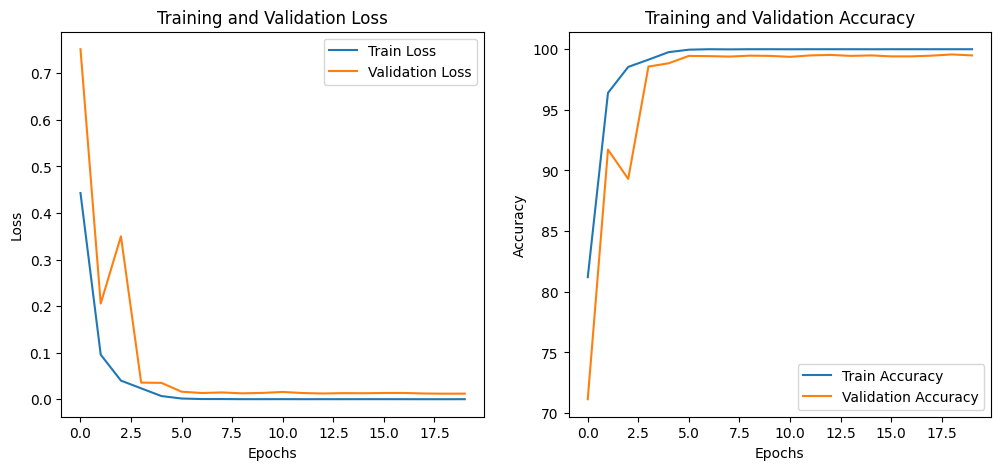

In [12]:
# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('GAN_plot.png')

plt.show()

In [25]:
classes = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

def show_saliency():
    """
    Compute a class saliency map for a single DL batch using the model for images X and labels y command and parameters.
    """
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        model.eval()

        for name, param in model.named_parameters():
            print(name, param.size())

        # Set requires_grad=True for model parameters
        for param in model.parameters():
            param.requires_grad = True

        images.requires_grad_()
        outputs_saliency = model(images)

        score, predicted = torch.max(outputs_saliency, 1)
        print(score[-1].requires_grad)

        model.zero_grad()

        score = score.sum()  # Ensure score is a scalar for backward()

        score.backward()

        saliency = images.grad.abs()
        saliency = saliency.cpu().detach().numpy()  # Move tensor to CPU and convert to NumPy array
        images = images.cpu().detach().numpy()  # Move tensor to CPU and convert to NumPy array


#         N = images.shape[0]
        N = 6
        for i in range(N):
            plt.subplot(2, N, i + 1)
            plt.imshow(images[i].squeeze()[0], cmap='gray')
            plt.title(classes[labels[i].numpy()])
            plt.axis('off')
            plt.subplot(2, N, N + i + 1)
            plt.imshow(saliency[i].squeeze()[0], cmap=plt.cm.hot)
            plt.axis('off')
            plt.gcf().set_size_inches(12, 5)
        plt.savefig('saliencybw.png')
        plt.show()

        return


conv1.weight torch.Size([64, 3, 7, 7])
bn1.weight torch.Size([64])
bn1.bias torch.Size([64])
layer1.0.conv1.weight torch.Size([64, 64, 3, 3])
layer1.0.bn1.weight torch.Size([64])
layer1.0.bn1.bias torch.Size([64])
layer1.0.conv2.weight torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight torch.Size([64])
layer1.0.bn2.bias torch.Size([64])
layer1.1.conv1.weight torch.Size([64, 64, 3, 3])
layer1.1.bn1.weight torch.Size([64])
layer1.1.bn1.bias torch.Size([64])
layer1.1.conv2.weight torch.Size([64, 64, 3, 3])
layer1.1.bn2.weight torch.Size([64])
layer1.1.bn2.bias torch.Size([64])
layer2.0.conv1.weight torch.Size([128, 64, 3, 3])
layer2.0.bn1.weight torch.Size([128])
layer2.0.bn1.bias torch.Size([128])
layer2.0.conv2.weight torch.Size([128, 128, 3, 3])
layer2.0.bn2.weight torch.Size([128])
layer2.0.bn2.bias torch.Size([128])
layer2.0.downsample.0.weight torch.Size([128, 64, 1, 1])
layer2.0.downsample.1.weight torch.Size([128])
layer2.0.downsample.1.bias torch.Size([128])
layer2.1.conv1.weight tor

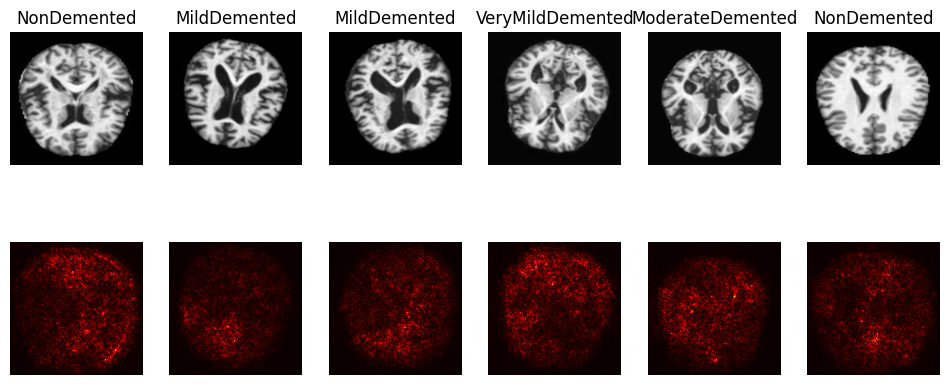

In [26]:
show_saliency()

512
0


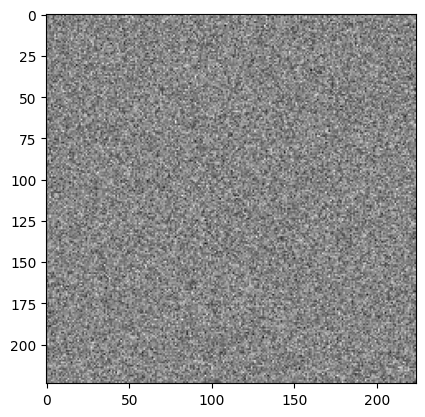

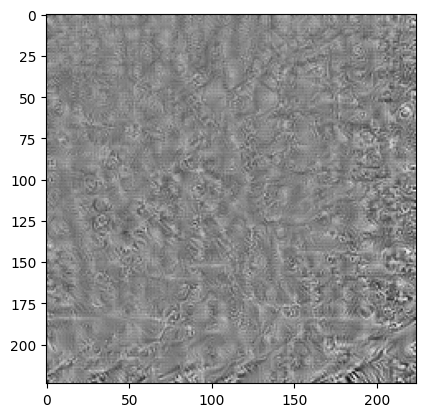

1


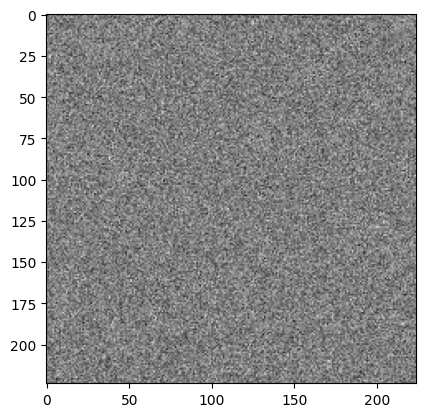

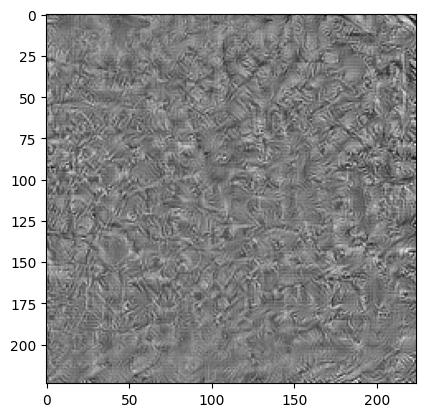

2


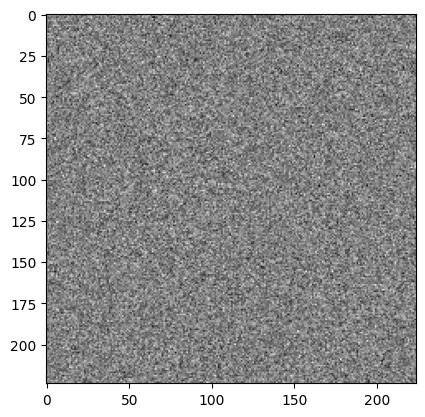

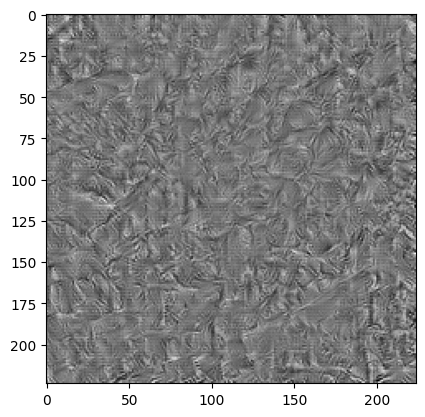

3


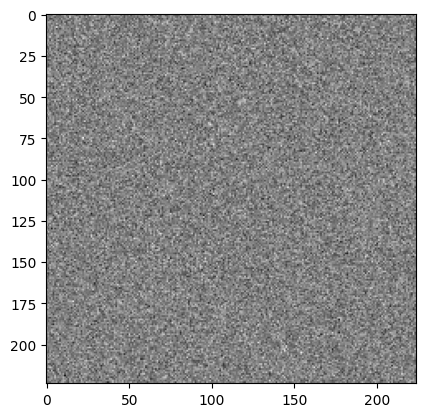

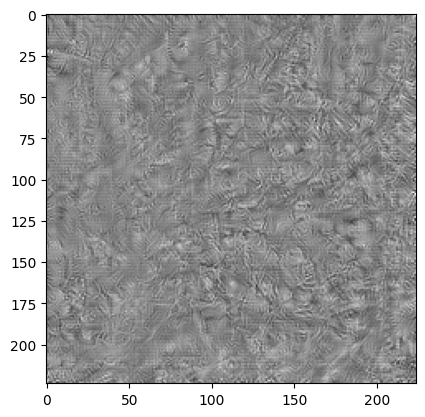

4


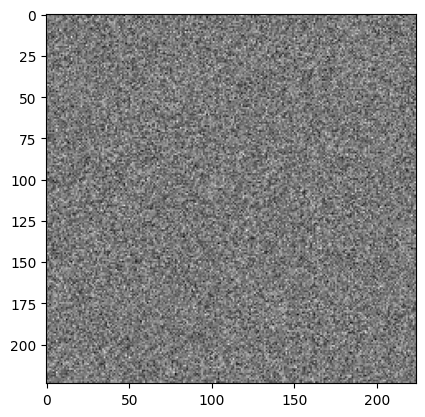

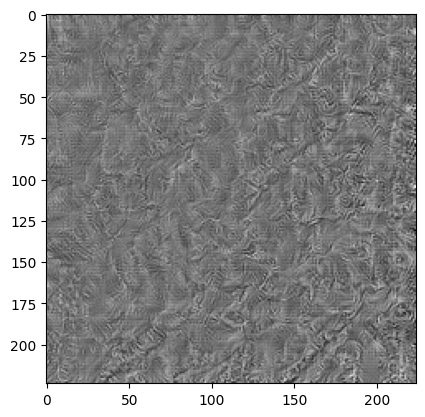

In [15]:
model.eval()  # Set the model to evaluation mode

# Select the target layer
target_layer = model.layer4

# Number of channels in the target layer
num_filters = target_layer[1].conv2.out_channels
print(num_filters)

# Forward hook to capture the activations of the target layer
activations = []
def forward_hook(module, input, output):
    activations.append(output)

target_layer.register_forward_hook(forward_hook)

num_iterations = 500
for filter_index in range(5):#range(num_filters):
    print(filter_index)
    # Initialize a random image
    input_image = torch.randn(1, 3, 224, 224, requires_grad=True)

    optimizer = torch.optim.Adam([input_image], lr=0.05)

    # Gradient ascent for the current filter
    for i in range(num_iterations):
        optimizer.zero_grad()
        output = model(input_image)

        # Loss is the mean activation of the current filter
        loss = -activations[-1][0, filter_index].mean()

        # Backward pass
        loss.backward()

        # Update the image
        optimizer.step()

        # Clear the activations
        activations = []

        if (i % (num_iterations - 1) == 0):
            plt.imshow(input_image.detach().numpy().squeeze().mean(axis=0),
                cmap='gray')
            plt.show()

In [16]:
import torch.nn.functional as F

class GuidedReLU(torch.nn.Module):
    def forward(self, input):
        '''
        Function designed to only allow positive gradients in backprop
        '''
        positive_mask = (input > 0).type_as(input)
        output = F.relu(input)
        return output * positive_mask

def replace_relu_with_guidedrelu(model):
    for name, module in model.named_children():
        if isinstance(module, torch.nn.ReLU):
            setattr(model, name, GuidedReLU())
        else:
            replace_relu_with_guidedrelu(module)

In [17]:
def guided_backprop(model, images, target_class):
    replace_relu_with_guidedrelu(model)

    model.eval()

    images.requires_grad_()
    outputs = model(images)

    model.zero_grad()

    one_hot_output = torch.zeros_like(outputs)
    one_hot_output[:, target_class] = 1

    outputs.backward(gradient=one_hot_output)

    saliency = images.grad.abs()
    return saliency

In [18]:
import numpy as np

def overlay_saliency_map(original_image, saliency_map, alpha=0.5):
    saliency_map = (saliency_map - np.min(saliency_map)) / (np.max(saliency_map) - np.min(saliency_map))

    cmap = plt.get_cmap('hot')

    saliency_colored = cmap(saliency_map)

    # Overlay the saliency map on the original image
    plt.imshow(original_image, cmap='gray')
    plt.imshow(saliency_colored, alpha=alpha)  # alpha controls the transparency
    plt.axis('off')
    plt.show()

In [21]:
images, _ = next(iter(train_loader))  # Get a batch of images
target_class = 2  # Class you want to visualize
saliency = guided_backprop(model, images, target_class)

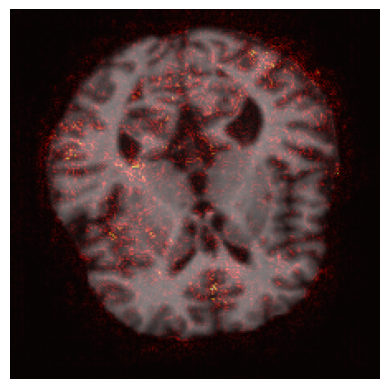

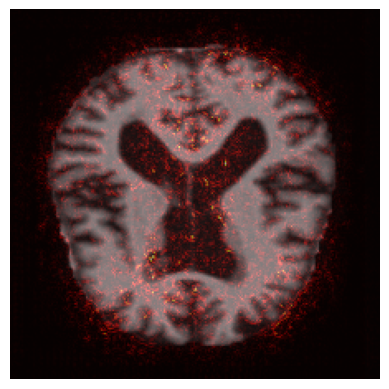

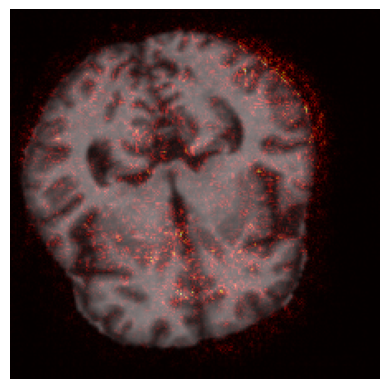

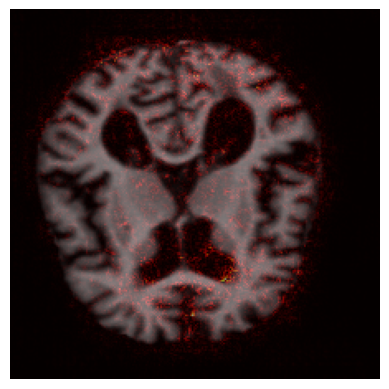

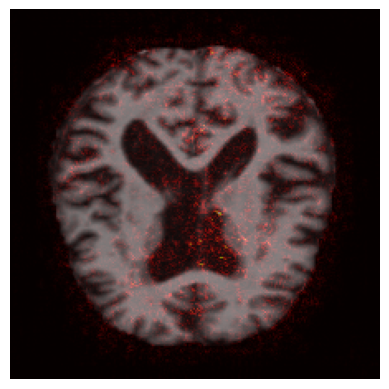

In [22]:
num_images = 5

for i in range(num_images):
    original_image = images[i].detach().numpy()[0]
    saliency_map = saliency[i].squeeze().detach().numpy()[0]
    overlay_saliency_map(original_image, saliency_map)

plt.show()